# QOSF QC Mentorship Program Screening Task

This notebook is made as a submission for the QOSF QC Mentorship Program's screening task.

By the way, I forgot to mention this in the application form: <br>
Even though I applied without a team, it doesn't mean I don't want to work in a team. I am willing to work either in a team or individually. If I were to be chosen for this program, I believe in QOSF judgment to make the decision whether to put me in a new team, in an existing team, or without a team.


## Task 2 (The Problem)

Implement a circuit that returns |01⟩ and |10⟩ with equal probability (50% for each). <br>
Requirements : <br>
The circuit should consist only of CNOTs, RXs and RYs. <br>
Start from all parameters in parametric gates being equal to 0 or randomly chosen. <br>
You should find the right set of parameters using gradient descent (you can use more advanced optimization methods if you like). <br>
Simulations must be done with sampling (i.e. a limited number of measurements per iteration) and noise. 

Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

$Bonus \ question$:
How to make sure you produce state  |01⟩  +  |10⟩  and not any other combination of |01⟩ + $e^{(i\phi)}$|10⟩ (for example |01⟩  -  |10⟩)


## 1. Packages and Frameworks

I used Qiskit and PennyLane packages to make the quantum circuit. For the simulator, I used Aer's QASM simulator package from Qiskit with ibmq_essex chip as the based model for the noise.

In [104]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

In [2]:
from qiskit import *
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import noise
provider = IBMQ.load_account()

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [105]:
# dependencies version
print("Qiskit version:", qiskit.__qiskit_version__)
print("\nNumpy version:", np.__version__)
print("\nMatplotlib version:", matplotlib.__version__)

Qiskit version: {'qiskit-terra': '0.15.2', 'qiskit-aer': '0.6.1', 'qiskit-ignis': '0.4.0', 'qiskit-ibmq-provider': '0.9.0', 'qiskit-aqua': '0.7.5', 'qiskit': '0.21.0'}

Numpy version: 1.18.1

Matplotlib version: 3.2.2


In [4]:
#Define the noise model based on the ibmq_essex chip
chip_name = 'ibmq_essex'
device = provider.get_backend(chip_name)
noise_model = noise.NoiseModel.from_backend(device)

simulator = Aer.get_backend('qasm_simulator')

This function below is to return the measurement results after running a quantum circuit for a certain number of shots. The simulator and noise model being used are as explained before.

In [5]:
# we can also run the circuit without noise by giving 0 to the noise_model argument
def run(mycircuit, iteration, simulator=simulator, noise_model=noise_model):
    if noise_model == 0:
        counts = execute(mycircuit, simulator, shots=iteration).result().get_counts(mycircuit)
    else:
        counts = execute(mycircuit, simulator, shots=iteration, noise_model=noise_model).result().get_counts(mycircuit)
    return counts

## 2. My Answers

I tried to use two different approaches in tackling the problem. The first one is by calculating the final statevector & the gradients by hand (analytically) and then formalized them into an algorithm with some assumptions. The second one is by using more general gradient calculation methods e.g. Parameter-shift Rule and Finite Difference.

I am treating this screening task as a chance for me to explore things deeper under the hood, hence for the optimization I tried to make nearly everything from scratch and not to use any packages/libraries. I knew that there are many Python packages/libraries to do optimization like PennyLane, TensorFlow, etc. and I use them frequently in other projects, I also realize that this code most likely will not be as efficient. But, using existing libraries probably won't be as fun, right? :)

## 2.1. First Approach: Calculating the gradient by hand.

The problem is basically to create a $\left|\Psi^{+}\right\rangle$ Bell state
$$\left|\Psi^{+}\right\rangle=\frac{1}{\sqrt{2}}(|01\rangle+|10\rangle)=\left[\begin{array}{c}
0 \\
\frac{1}{\sqrt{2}} \\
\frac{1}{\sqrt{2}} \\
0
\end{array}\right]$$
from a $\left|00\right\rangle$ state using only CNOTs, RXs and RYs (or the subset). One of the easiest way to do this is by using a Hadamard gate on the first qubit, an X gate on the second qubit, then followed by a CNOT gate with the first qubit as control (see circuit below).

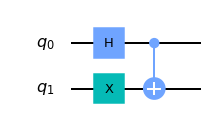

In [6]:
qc = QuantumCircuit(2)
qc.h(0)
qc.x(1)
qc.cx(0,1)

qc.draw('mpl')

As a proof, let's see the statevector of the qubits after passing this circuit

In [7]:
qubit = Statevector.from_label('00')
qubit_output = qubit.evolve(qc)
print(qubit_output.data)

[0.        +0.j 0.70710678+0.j 0.70710678+0.j 0.        +0.j]


the result is indeed correct.

Now the question becomes how to decompose a Hadamard and X gate to using only CNOTs, RXs and RYs. <br>
A Hadamard gate rotates a qubit from the computational basis to Hadamard basis. This is equal to the rotation of $\frac{\pi}{2}$ around the Y-axis. <br>
An X gate flips a qubit in the computational basis. This is equal to the rotation of $\pi$ around the Y-axis.

$$
R Y(\theta)=\exp \left(-i \frac{\theta}{2} Y\right)=\left[\begin{array}{cc}
\cos \frac{\theta}{2} & -\sin \frac{\theta}{2} \\
\sin \frac{\theta}{2} & \cos \frac{\theta}{2}
\end{array}\right]
$$

So we can use RY gates to recreate the circuit above. The first one, $RY(θ_1=\frac{\pi}{2})$ can replace the Hadamard gate, while the second one, $RY(θ_2=\pi)$ can replace the X gate. Let's test this circuit

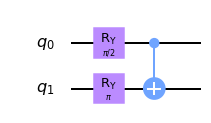

In [8]:
qc = QuantumCircuit(2)
qc.ry(np.pi/2, 0)
qc.ry(np.pi, 1)
qc.cx(0,1)

qc.draw('mpl')

In [9]:
qubit = Statevector.from_label('00')
qubit_output = qubit.evolve(qc)
print(qubit_output.data)

[4.32978028e-17+0.j 7.07106781e-01+0.j 7.07106781e-01+0.j
 4.32978028e-17+0.j]


the result is indeed the same as before. 

To make things easy, this function below will create this circuit by using arguments $θ_1$ and $θ_2$ as the input angle for both RY gates respectively.

In [10]:
def circuit(θ1, θ2):
    qc = QuantumCircuit(2,2)
    qc.ry(θ1, 0)
    qc.ry(θ2, 1)
    qc.cx(0,1)
    qc.measure([0,1], [0,1])
    return qc

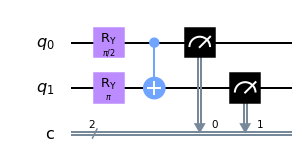

In [11]:
circuit(np.pi/2, np.pi).draw('mpl')

The problem states that we have to find both parameters ($θ_1$ and $θ_2$) using gradient descent or other optimization algorithms and start from all parameters are equal to zero or randomly chosen.

I chose to$\ start \ from \ zero \ and \ use \ gradient \ descent$ to find these parameters.

### Getting the statevector's entries from measurements

Let's first calculate the final statevector of this circuit if we keep the parameters as variables.

$$
R Y(\theta_{1})=\left[\begin{array}{cc}
\cos \frac{\theta_{1}}{2} & -\sin \frac{\theta_{1}}{2} \\
\sin \frac{\theta_{1}}{2} & \cos \frac{\theta_{1}}{2}
\end{array}\right]=\left[\begin{array}{cc}
\alpha & -\beta \\
\beta & \alpha
\end{array}\right]
$$

$$
R Y(\theta_{2})=\left[\begin{array}{cc}
\cos \frac{\theta_{2}}{2} & -\sin \frac{\theta_{2}}{2} \\
\sin \frac{\theta_{2}}{2} & \cos \frac{\theta_{2}}{2}
\end{array}\right]=\left[\begin{array}{cc}
\epsilon & -\delta \\
\delta & \epsilon
\end{array}\right]
$$

To make it shorter, I replace the entry of the matrix with
$$
\cos \frac{\theta_{1}}{2} = \alpha \\
\sin \frac{\theta_{1}}{2} = \beta \\
\cos \frac{\theta_{2}}{2} = \epsilon \\
\sin \frac{\theta_{2}}{2} = \delta
$$

After passing the circuit, the statevector becomes
$$
CNOT [R Y(\theta_{1}) |0\rangle \otimes R Y(\theta_{2}) |0\rangle] = \left[\begin{array}{l}
\alpha \epsilon \\
\alpha \delta \\
\beta \delta \\
\beta \epsilon
\end{array}\right]
$$

$$
\left[\begin{array}{l}
\alpha \epsilon \\
\alpha \delta \\
\beta \delta \\
\beta \epsilon
\end{array}\right]=\alpha \epsilon\left[\begin{array}{l}
1 \\
0 \\
0 \\
0
\end{array}\right]+\alpha \delta\left[\begin{array}{l}
0 \\
1 \\
0 \\
0
\end{array}\right]+\beta \delta\left[\begin{array}{l}
0 \\
0 \\
1 \\
0
\end{array}\right]+\beta \epsilon\left[\begin{array}{l}
0 \\
0 \\
0 \\
1
\end{array}\right] = \alpha \epsilon|00\rangle+\alpha \delta|01\rangle+\beta \delta|10\rangle+\beta \epsilon|11\rangle
$$

It turns out we can get the value of $\alpha\epsilon, \alpha\delta, \beta\delta,$ and $\beta\epsilon$ from measurements. The probability of measuring a particular state will give us the value of certain variables. For example probability of measuring $|00\rangle$ state will give us $(\alpha \epsilon)^2$

$$
P_{(00)}=\left| \langle 00 \mid \left(\alpha \epsilon|00\rangle+\alpha \delta|01\rangle+\beta \delta|10\rangle+\beta \epsilon|11\rangle \right) \right|^2 = (\alpha \epsilon)^2
\\
\alpha \epsilon = P_{(00)}^{1/2}
$$

This equation holds as long as both $\alpha$ and $\epsilon$ are non-negative. Since we start from zero for both parameters and we stop the search at $\theta_{1} = \frac{\pi}{2}$ and $\theta_{2} = \pi$, both $\sin(\frac{\theta}{2})$ and $\cos(\frac{\theta}{2})$ are non-negative for the whole searching process. This also apply to the rest of the states, so we have

$$
\alpha \delta = P_{(01)}^{1/2}\\
\beta \delta = P_{(10)}^{1/2}\\
\beta \epsilon = P_{(11)}^{1/2}
$$

Note: <br>
The probability of measuring a particular state is equal to how many times we measure that state divided by the number of shots.

### Loss function

We will use the mean-squared error (MSE) $J$ as the loss function. We can calculate the MSE as function of $θ_1$ and $θ_2$ for all entries of this statevector to the statevector that we want.
$$
\left[\begin{array}{l}
\alpha \epsilon \\
\alpha \delta \\
\beta \delta \\
\beta \epsilon
\end{array}\right] → \left[\begin{array}{c}
0 \\
\frac{1}{\sqrt{2}} \\
\frac{1}{\sqrt{2}} \\
0
\end{array}\right]
$$

$$
J(\theta_{1}, \theta_{2})=\frac{(\alpha \varepsilon-0)^{2}+(\alpha \delta-1 / \sqrt{2})^{2}+(\beta \delta-1 / \sqrt{2})^{2}+(\beta \varepsilon-0)^{2}}{4}=\frac{(\alpha \varepsilon)^{2}+(\alpha \delta-1 / \sqrt{2})^{2}+(\beta \delta-1 / \sqrt{2})^{2}+(\beta \varepsilon)^{2}}{4}
$$

Since $\alpha\epsilon, \alpha\delta, \beta\delta,$ and $\beta\epsilon$ is a function of $θ_1$ and $θ_2$, this mean we can calculate the loss by using the parameters $θ_1$ and $θ_2$ that we have (exact form). By using the $θ_1$ and $θ_2$ rather than the measurement results to calculate the loss, we can get a more exact value of the loss so the searching iteration can be stopped faster (I will use this MSE value as a cue when to stop the training). Don't worry, this MSE function will not be used to update the parameters, only to stop the iteration.

In [12]:
# MSE as a function of θ1 and θ2
def mse_theta(θ1, θ2):
    J = ((np.cos(θ1/2)*np.cos(θ2/2))**2 + (np.cos(θ1/2)*np.sin(θ2/2) - 1/np.sqrt(2))**2 + (np.sin(θ1/2)*np.sin(θ2/2) - 1/np.sqrt(2))**2 + (np.sin(θ1/2)*np.cos(θ2/2))**2)/4
    
    return J

I also created a function to calculate the MSE from measurement results. This one will not be exact since it is a function of probability from measurements that may or may not represent the correct loss. We will analyze the difference between the two MSE function later on.

$$
J(P_{(00)}, P_{(01)}, P_{(10)}, P_{(11)})=\frac{P_{(00)}+\left(P_{(01)}^{1/2}-\frac{1}{\sqrt{2}}\right)^{2}+\left(P_{(10)}^{1/2}-\frac{1}{\sqrt{2}}\right)^{2}+P_{(11)}}{4}
$$

In [13]:
# MSE as a function of measurement results
def mse_meas(P_00_sqrt, P_01_sqrt, P_10_sqrt, P_11_sqrt):
    J = ((P_00_sqrt)**2 + (P_01_sqrt - 1/np.sqrt(2))**2 + (P_10_sqrt - 1/np.sqrt(2))**2 + (P_11_sqrt)**2)/4
    
    return J

### Calculating the gradients and updating the parameters

Next, we need to calculate the gradient of this loss function. Using the chain rule, we get

$$
\frac{\partial J}{\partial \theta_{1}}=\frac{\varepsilon^{2}\alpha(-\beta)+\left(\alpha \delta-\frac{1}{\sqrt{2}}\right) \delta(-\beta)+\left(\beta \delta-\frac{1}{\sqrt{2}}\right) \delta \alpha+\varepsilon^{2}\beta \alpha}{4}
=
\frac{-P_{(00)}^{1 / 2} P_{(11)}^{1 / 2}-\left(P_{(01)}^{1 / 2}-1 / \sqrt{2}\right) P_{(10)}^{1 / 2}+\left(P_{(10)}^{1 / 2}-1 / \sqrt{2}\right) P_{(01)}^{1 / 2}+P_{(00)}^{1 / 2} P_{(11)}^{1 / 2}}{4}
$$

$$
\frac{\partial J}{\partial \theta_{2}}=
\frac{\alpha^{2} \varepsilon(-\delta)+\left(\alpha \delta-\frac{1}{\sqrt{2}}\right) \alpha \varepsilon+\left(\beta \delta-\frac{1}{\sqrt{2}}\right) \beta \varepsilon+\beta^{2} \varepsilon(-\delta)}{4}=
\frac{-P_{(00)}^{1 / 2} P_{(01)}^{1 / 2}+\left(P_{(01)}^{1 / 2}-1 / \sqrt{2}\right) P_{(00)}^{1 / 2}+\left(P_{(10)}^{1 / 2}-1 / \sqrt{2}\right) P_{(11)}^{1 / 2}-P_{(10)}^{1 / 2} P_{(11)}^{1 / 2}}{4}
$$

This gradients will be used to update the parameters as follow

$$
\theta_{1}^{i+1}=\theta_{1}^{i}- \eta_{_1} \frac{\partial J}{\partial \theta_{1}^{i}}\\
\theta_{2}^{i+1}=\theta_{2}^{i}- \eta_{_2} \frac{\partial J}{\partial \theta_{2}^{i}}
$$

where $\eta$ is the learning rate, I used different values of learning rate for $θ_1$ and $θ_2$ for easier tuning. Superscript $i$ and $i+1$ mean they are the parameters at the step $i$ and $i+1$ respectively.

In [14]:
# calculate the gradients and update the parameters
def update_param(θ1, θ2, P_00_sqrt, P_01_sqrt, P_10_sqrt, P_11_sqrt, learning_rate):
    θ1 = θ1 - learning_rate[0]*(-P_00_sqrt*P_11_sqrt - (P_01_sqrt - 1/np.sqrt(2))*P_10_sqrt + (P_10_sqrt - 1/np.sqrt(2))*P_01_sqrt + P_00_sqrt*P_11_sqrt)/4
    θ2 = θ2 - learning_rate[1]*(-P_00_sqrt*P_01_sqrt + (P_01_sqrt - 1/np.sqrt(2))*P_00_sqrt + (P_10_sqrt - 1/np.sqrt(2))*P_11_sqrt - P_10_sqrt*P_11_sqrt)/4
    
    return (θ1, θ2)

### Training/Searching the correct parameters

As all the ingredients are obtained, we can now do the iteration to find the correct parameters. <br>
Remember that we want $θ_1=\frac{\pi}{2}$, $θ_2=\pi$, and $J(θ_1, θ_2)$ to be as small as possible.

Below is the flowchart of the program
<img src="files/flowchart.png" width=400px>

For the initialization of the parameters and constants: <br>
I set both $θ_1$ and $θ_2$ to zero, $J(θ_1, θ_2)$ max is 0.0001 (means that the search will be stopped once we reach the loss lower than 0.0001), maximum iteration is 5000 (means the search will be stopped once we reach the 5000th parameters update). The search will be done using shots = 1000, 100, 10, and 1, and the learning rate will be set differently for every shots (manually tuned).

At every parameters update and loss calculation, the parameters and the loss are stored in their own respective lists so they can be plotted later (I don't put this step in the flowchart to reduce the chart complexity, I only put the essential steps there).

In [65]:
# INITIALIZATION

# initial parameters and constants
θ1 = 0
θ2 = 0
max_loss = 0.0001  # maximum loss, the search will be stopped if the loss reachs this number (or lower)
max_iter = 5000  # maximum steps of parameters update

# initial error
error = mse_theta(θ1, θ2)
error_meas = mse_meas(1, 0, 0, 0)

# hyperparameters
shots = [1000, 100, 10, 1]  # number of shots for every measurement
learning_rate = [[0.1, 0.05], [0.1, 0.05], [0.1, 0.05], [0.1, 0.05]]

# list to save historical data
θ1_history = [np.array([θ1]), np.array([θ1]), np.array([θ1]), np.array([θ1])]
θ2_history = [np.array([θ2]), np.array([θ2]), np.array([θ2]), np.array([θ2])]
error_theta_history = [np.array([error]), np.array([error]), np.array([error]), np.array([error])]
error_meas_history = [np.array([error_meas]), np.array([error_meas]), np.array([error_meas]), np.array([error_meas])]

In [66]:
# SEARCHING FOR THE PARAMETERS

# loop for every shots
for i in range (len(shots)):

    # initialization
    steps = 0
    θ1 = 0
    θ2 = 0
    error = mse_theta(θ1, θ2)

    # searching loop
    while error > max_loss:
        # target: J(θ1,θ2) <= max_loss

        # run the circuit and get the measurement results
        result = run(circuit(θ1, θ2), shots[i])
        probs = [0,0,0,0]  # reset the probability distribution
        for x, y in result.items():
            probs[2*int(x[0]) + 1*int(x[1])] = y/shots[i]
        # note that in Qiskit, the position of the qubits are flipped
        # hence we take the '10' result for '01' probability and vice-versa
        P_00_sqrt, P_10_sqrt, P_01_sqrt, P_11_sqrt = np.sqrt(probs)

        # update the parameters
        θ1, θ2 = update_param(θ1, θ2, P_00_sqrt, P_01_sqrt, P_10_sqrt, P_11_sqrt, learning_rate[i])

        # calculate the error, both J(θ1,θ2) and J(P(00), P(01), P(10), P(11))
        error = mse_theta(θ1, θ2)
        error_meas = mse_meas(P_00_sqrt, P_01_sqrt, P_10_sqrt, P_11_sqrt)

        # log the historical data
        θ1_history[i] = np.append(θ1_history[i], θ1)
        θ2_history[i] = np.append(θ2_history[i], θ2)
        error_theta_history[i] = np.append(error_theta_history[i], error)
        error_meas_history[i] = np.append(error_meas_history[i], error_meas)

        # increase the step count
        steps += 1

        # if the step count reachs max iter, stop the search
        if steps == max_iter:
            print("Training takes too long. Stopping...")
            break

    # print stuffs
    print("Shots = ", shots[i])
    print("Total Iteration:", steps)
    print("Final angle:" + " θ1 = " + str(θ1) + ", θ2 = " + str(θ2))
    print("Correct/target angle:" + " θ1 = " + str(np.pi/2) + ", θ2 = " + str(np.pi))
    print("Final mean-squared error:", error)
    print("\n")


Shots =  1000
Total Iteration: 475
Final angle: θ1 = 1.5512218545879801, θ2 = 3.110715180417428
Correct/target angle: θ1 = 1.5707963267948966, θ2 = 3.141592653589793
Final mean-squared error: 8.353191580895917e-05


Shots =  100
Total Iteration: 478
Final angle: θ1 = 1.562681715861645, θ2 = 3.103250780429521
Correct/target angle: θ1 = 1.5707963267948966, θ2 = 3.141592653589793
Final mean-squared error: 9.599305835191534e-05


Shots =  10
Total Iteration: 613
Final angle: θ1 = 1.5401746672174939, θ2 = 3.1181245722763395
Correct/target angle: θ1 = 1.5707963267948966, θ2 = 3.141592653589793
Final mean-squared error: 9.302173043407064e-05


Shots =  1
Total Iteration: 1360
Final angle: θ1 = 1.5733125881400665, θ2 = 3.102431002455972
Correct/target angle: θ1 = 1.5707963267948966, θ2 = 3.141592653589793
Final mean-squared error: 9.624476724831887e-05




### Analysis of the results

As we can see, this program is able to find the optimized parameters within 0.0001 loss.

The number of shots is crucial since the parameters update depends on the probability from the measurements. We can see that more iterations are needed for smaller shots, this is because the probability distribution that we get from the measurements becomes less and less accurate as the number of shots becomes smaller. Inaccurate probability will cause inaccurate parameters update, making the searching process unstable (we will be able to see this 'unstability' better when we discuss the plot of $θ_{1}$ and $θ_{2}$ later).

For low number of shots, we can compensate this slow search by increasing the learning rate. But it is actually not that good to use too high of learning rate because the searching process will be prone to overshooting and unstable learning, the search will fail if we set the loss smaller, say to $10^{-8}$, because it needs a more precise optimized parameters to reach that loss and the parameters will never land on the more precise values since the update step size (learning rate) is too large.

#### Result Plots

I plotted the historical data of the searching process below. After every plot, I put some important takeaways related to the plot.

This is the histogram of the state that we will get if we use the parameters that we found for the circuit. <br>
I used 1000 shots for this measurement just to plot the histogram.

Histogram of the circuit's measurement results using the final angle for 1000 shots


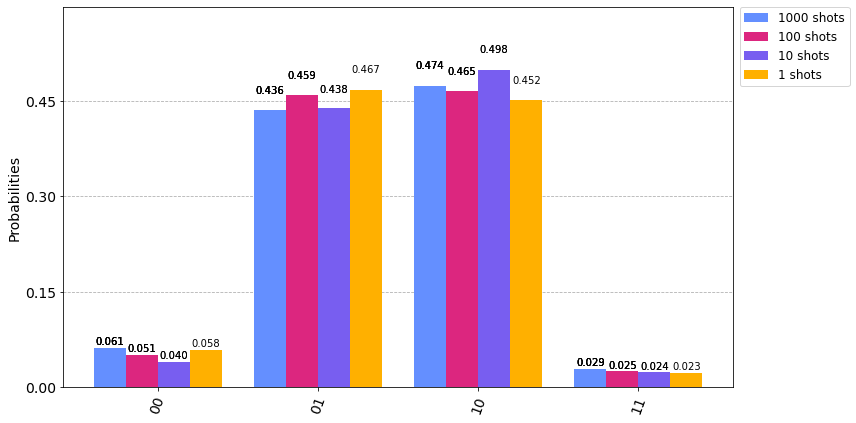

In [67]:
print("Histogram of the circuit's measurement results using the final angle for 1000 shots")

# Execute the circuit using the optimized parameters for 1000 shots
counts_1000  = run(circuit(θ1_history[0][-1], θ2_history[0][-1]), 1000)
counts_100  = run(circuit(θ1_history[1][-1], θ2_history[1][-1]), 1000)
counts_10  = run(circuit(θ1_history[2][-1], θ2_history[2][-1]), 1000)
counts_1  = run(circuit(θ1_history[3][-1], θ2_history[3][-1]), 1000)

# Plot results with legend
legend = ['1000 shots', '100 shots', '10 shots', '1 shots']
plot_histogram([counts_1000, counts_100, counts_10, counts_1], legend=legend, figsize=(12,7))


The histogram shows that by using the optimized parameters, we will get the |01⟩ and |10⟩ state with about equal probability most of the time. The |00⟩ and |11⟩ state that appear are mostly because of the noise. Let's run the circuit again but with non-noisy QASM simulator.

Histogram of the circuit's measurement results using the final angle for 1000 shots (without noise)


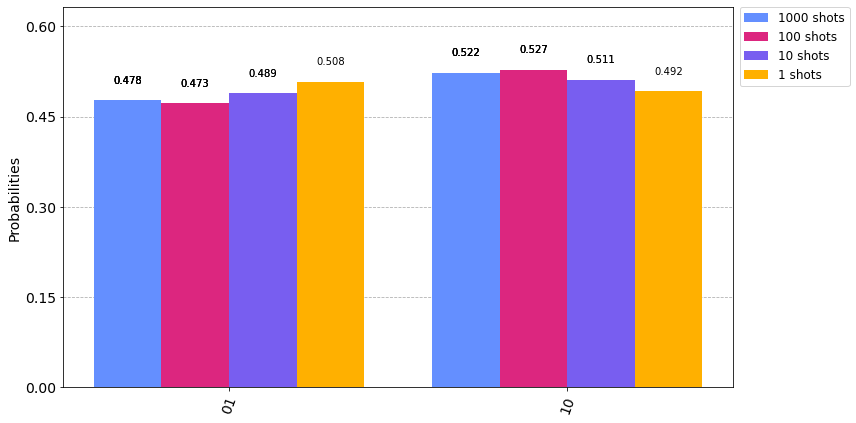

In [68]:
print("Histogram of the circuit's measurement results using the final angle for 1000 shots (without noise)")

# Execute the circuit using the optimized parameters for 1000 shots
counts_1000  = run(circuit(θ1_history[0][-1], θ2_history[0][-1]), 1000, noise_model=0)
counts_100  = run(circuit(θ1_history[1][-1], θ2_history[1][-1]), 1000, noise_model=0)
counts_10  = run(circuit(θ1_history[2][-1], θ2_history[2][-1]), 1000, noise_model=0)
counts_1  = run(circuit(θ1_history[3][-1], θ2_history[3][-1]), 1000, noise_model=0)

# Plot results with legend
legend = ['1000 shots', '100 shots', '10 shots', '1 shots']
plot_histogram([counts_1000, counts_100, counts_10, counts_1], legend=legend, figsize=(12,7))


By using the non-noisy simulator, the |00⟩ and |11⟩ state disappear.

Below is the plots for $θ_{1}$ and $θ_{2}$ at every parameters update step.

In [40]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

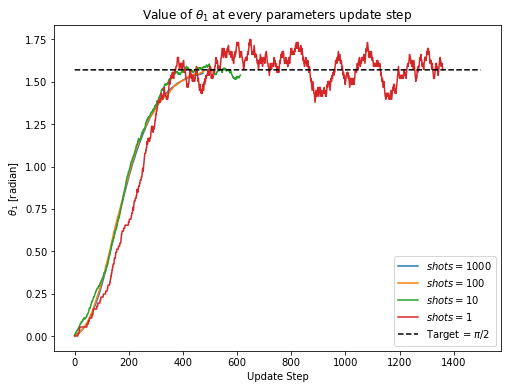

In [74]:
plt.plot(θ1_history[0], label='$shots = 1000$')
plt.plot(θ1_history[1], label='$shots = 100$')
plt.plot(θ1_history[2], label='$shots = 10$')
plt.plot(θ1_history[3], label='$shots = 1$')
plt.plot(np.linspace(np.pi/2, np.pi/2, 1500), color='black', linestyle='--', label='Target = $\pi/2$')

plt.title('Value of $θ_{1}$ at every parameters update step')
plt.xlabel('Update Step')
plt.ylabel('$θ_{1}$ [radian]')
plt.legend()

plt.show()

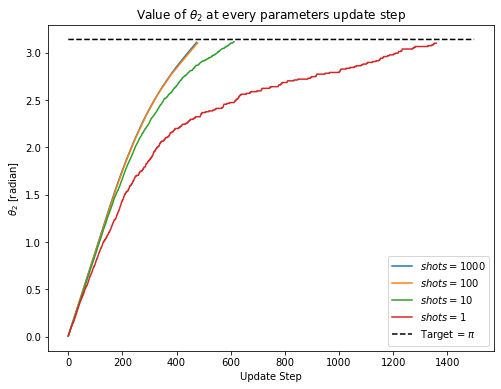

In [75]:
plt.plot(θ2_history[0], label='$shots = 1000$')
plt.plot(θ2_history[1], label='$shots = 100$')
plt.plot(θ2_history[2], label='$shots = 10$')
plt.plot(θ2_history[3], label='$shots = 1$')
plt.plot(np.linspace(np.pi, np.pi, 1500), color='black', linestyle='--', label='Target = $\pi$')

plt.title('Value of $θ_{2}$ at every parameters update step')
plt.xlabel('Update Step')
plt.ylabel('$θ_{2}$ [radian]')
plt.legend()

plt.show()

We can see here that with less and less shots, the searching process becomes more and more unstable. It is clear that both $θ_{1}$ and $θ_{2}$ plots with 1000 and 100 shots are smooth. The plots start to wiggle a little bit with 10 shots, and they are clearly wiggling a lot with 1 shots.

Below is the plots for MSE as a function of $θ_{1}$ and $θ_{2}$, and MSE as a function of probability distribution from measurement results calculated after every parameters update.

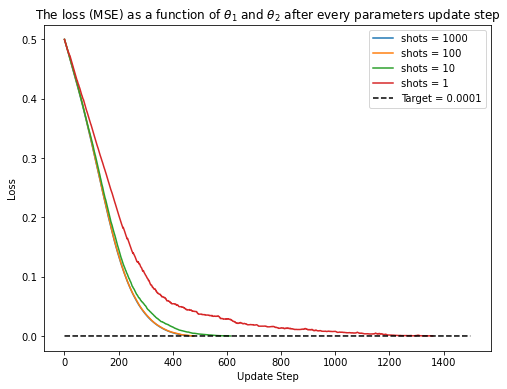

In [77]:
plt.plot(error_theta_history[0], label='shots = 1000')
plt.plot(error_theta_history[1], label='shots = 100')
plt.plot(error_theta_history[2], label='shots = 10')
plt.plot(error_theta_history[3], label='shots = 1')
plt.plot(np.linspace(0.0001, 0.0001, 1500), color='black', linestyle='--', label='Target = 0.0001')

plt.title('The loss (MSE) as a function of $θ_{1}$ and $θ_{2}$ after every parameters update step')
plt.xlabel('Update Step')
plt.ylabel('Loss')
plt.legend()

plt.show()

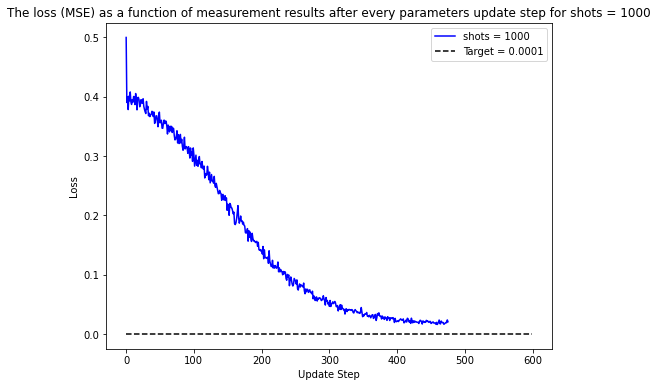

In [92]:
plt.plot(error_meas_history[0], label='shots = 1000', color='blue')
plt.plot(np.linspace(0.0001, 0.0001, 600), color='black', linestyle='--', label='Target = 0.0001')

plt.title('The loss (MSE) as a function of measurement results after every parameters update step for shots = 1000')
plt.xlabel('Update Step')
plt.ylabel('Loss')
plt.legend()

plt.show()

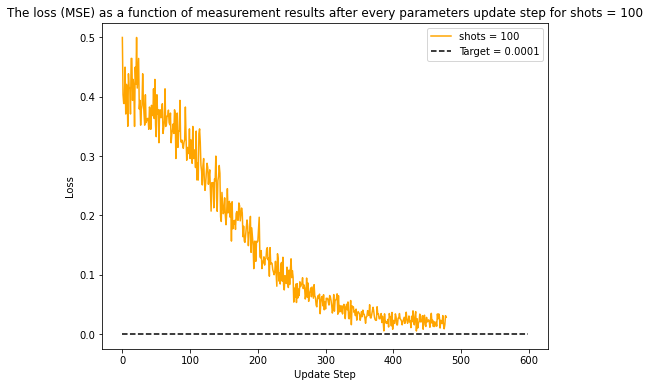

In [95]:
plt.plot(error_meas_history[1], label='shots = 100', color='orange')
plt.plot(np.linspace(0.0001, 0.0001, 600), color='black', linestyle='--', label='Target = 0.0001')

plt.title('The loss (MSE) as a function of measurement results after every parameters update step for shots = 100')
plt.xlabel('Update Step')
plt.ylabel('Loss')
plt.legend()

plt.show()

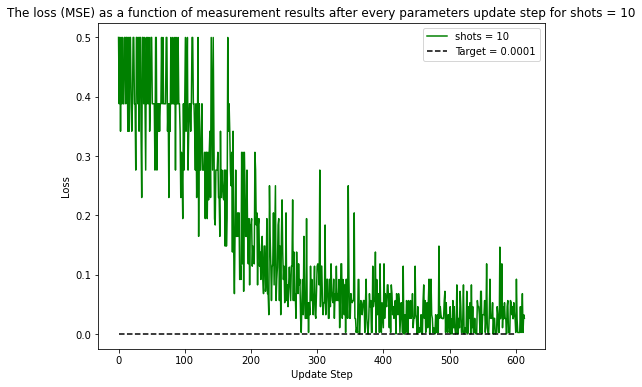

In [97]:
plt.plot(error_meas_history[2], label='shots = 10', color='green')
plt.plot(np.linspace(0.0001, 0.0001, 600), color='black', linestyle='--', label='Target = 0.0001')

plt.title('The loss (MSE) as a function of measurement results after every parameters update step for shots = 10')
plt.xlabel('Update Step')
plt.ylabel('Loss')
plt.legend()

plt.show()

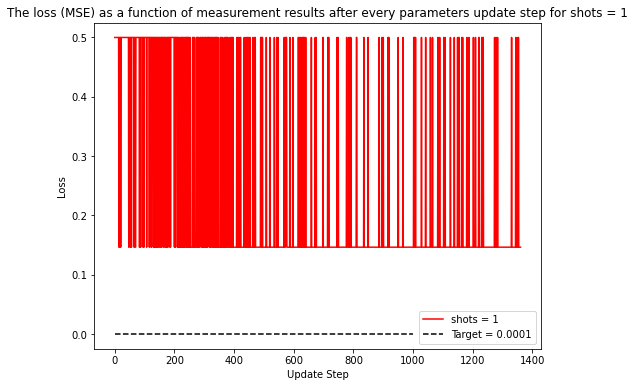

In [109]:
plt.plot(error_meas_history[3], label='shots = 1', color='red')
plt.plot(np.linspace(0.0001, 0.0001, 1000), color='black', linestyle='--', label='Target = 0.0001')

plt.title('The loss (MSE) as a function of measurement results after every parameters update step for shots = 1')
plt.xlabel('Update Step')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

It is shown here that the MSE that is calculated using the probability distribution from measurement results is inaccurate, it even didn't go down and just went back and forth randomly with about constant average for 1 shots. The MSE that is calculated using the parameters $θ_{1}$ and $θ_{2}$ is much smoother and closer to the target.

Since the circuit is quite simple, we can calculate by hand the final result of the statevector and then use it to calculate the loss as a function of $θ_{1}$ and $θ_{2}$ (the exact form, immune to noise). For a much more complex circuit, it is hard to calculate the final statevector by hand, hence most likely we will need to use the MSE as a function of the measurement results. But using this function as the loss function will have some probability to cause the optimizer to fail to reach the optimized parameters because:

1). We can't get the correct probability distribution in this case for 1 shots even wihtout noise since the measurements will give 100% probability of getting one particular state and 0% for the rest everytime. The MSE is calculated as a function of the probability of all states, hence it will give incorrect result everytime.

2). If we use more shots, there is still some probability that we can't reach the exact value of the loss, because it is still affected by the noise. As we can see from the 1000, 100 and 10 shots cases, all losses are going down but they are stuck and unable to reach the target (even though it actually already reached the target if we calculate the loss using the exact form) because the noise still messed up the probability. From this case, we can also see that more shots means we can calculate the loss more accurately as the effect of noise on the probability is reduced with more shots.

### Answer to the bonus question

How to make sure you produce state |01⟩ + |10⟩ and not any other combination of |01⟩ + $e^{(i\phi)}$|10⟩ (for example |01⟩ - |10⟩)

This question can be translated to "How to make sure both qubits are not picking up difference in the relative phase?". We would like to have state

$$
|\psi\rangle = \zeta|01\rangle + \kappa|10\rangle
$$

with equal probability. As long as we can make sure $\zeta$ and $\kappa$ are both real, have the same sign (both plus or both minus), and have the same magnitude, we can safely say that we have produced $\frac{|01⟩ + |10⟩}{\sqrt{2}}$ state.

We have already calculate that
$$
CNOT [R Y(\theta_{1}) |0\rangle \otimes R Y(\theta_{2}) |0\rangle] = \alpha \epsilon|00\rangle+\alpha \delta|01\rangle+\beta \delta|10\rangle+\beta \epsilon|11\rangle\\
= \cos \frac{\theta_{1}}{2} \cos \frac{\theta_{2}}{2}|00\rangle + \cos \frac{\theta_{1}}{2} \sin \frac{\theta_{2}}{2}|01\rangle + \sin \frac{\theta_{1}}{2} \sin \frac{\theta_{2}}{2}|10\rangle + \sin \frac{\theta_{1}}{2} \cos \frac{\theta_{2}}{2}|11\rangle
$$

so

$$
\zeta = \cos \frac{\theta_{1}}{2} \sin \frac{\theta_{2}}{2}\\
\kappa = \sin \frac{\theta_{1}}{2} \sin \frac{\theta_{2}}{2}
$$

1). Since we only use RY gate, we do not introduce a $\phi$ rotation to our state, so it will not pickup any imaginary components.

2). The gradient descent will minimze the loss function. Since our loss function's objective is to make both state |01⟩ and |10⟩ have equal probability, the magnitude of $\zeta$ and $\kappa$ should be around the same if the optimization process is successful.

3). The value of $\sin \frac{\theta}{2}$ and $\cos \frac{\theta}{2}$ is always non-negative for $0 \leq \theta \leq \pi$ (I actually already used this argument when I explained the $\alpha \epsilon = P_{(00)}^{1/2}$ part). The value of $\cos \frac{\theta}{2}$ is always non-positive for $\pi \leq \theta \leq 2\pi$, and the value of $\sin \frac{\theta}{2}$ is always non-negative for $\pi \leq \theta \leq 2\pi$. For the first parameter, since we start from $θ_{1}=0$ and ends around $θ_{1}=\frac{\pi}{2}$, we are sure that both sine and cosine will be positive because $0 \leq \theta_{1} \leq \pi$. To make $\zeta$ and $\kappa$ have the same sign, we have to keep $\theta_{2}$ in the range of $0 \leq \theta_{2} \leq \pi$, because if $\theta_{2}$ is a little bit more than $\pi$ the value of $\zeta$ will be negative while the value of $\kappa$ will still be positive (different sign). The target for $\theta_{2}$ is $\pi$, so as long as we successfully carry out the optimization without overshooting, the value of $\theta_{2}$ should still be less than $\pi$ (as we can see from the optimization result, we always ends on $\theta_{2}$ around 3.11). In short, to keep both $\zeta$ and $\kappa$ have the same sign we need to make sure our learning rate is not too high to cause overshooting.

## 2.2. Second Approach: Calculating the gradient using Parameter-shift Rule (PSR) and Finite Difference (FD).

The loss function that we used before is unrealistic for a more general case. To change this into a more realistic one, we cannot use the part where we assume $\alpha \epsilon = P_{(00)}^{1/2}$ since it depends on all parameters stay in the range of $0 \leq \theta \leq \pi$. The other simplest loss function that we can use without this assumption is by just subtracting the probability of all the states from measurements to the probability that we want and squaring them. Since we want $P_{00} = 0$, $P_{01} = \frac{1}{2}$, $P_{10} = \frac{1}{2}$, and $P_{11} = 0$, we get

$$
J = \frac{(P_{00}-0)^2 + (P_{01}-\frac{1}{2})^2 + (P_{10}-\frac{1}{2})^2 + (P_{11}-0)^2}{4}
$$

In [15]:
# new loss function
def mse_2(theta, shots):
    result = run(circuit(theta[0], theta[1]), shots)
    
    probs = [0,0,0,0]  # reset the probability distribution
    for x, y in result.items():
        probs[2*int(x[0]) + 1*int(x[1])] = y/shots
    # note that in Qiskit, the position of the qubits are flipped
    # hence we take the '10' result for '01' probability and vice-versa
    P_00, P_10, P_01, P_11 = probs
    
    return (P_00**2 + (P_01 - 1/2)**2 + (P_10 - 1/2)**2 + P_11**2)/4

### Others gradient calculation method

There are some other ways to calculate the gradient of the loss function, for example PSR and FD.<br>

#### 1). PSR <br>
PSR is an exact method in theory (not an approximation!) to calculate the gradient of a quantum circuit. If we have an evaluation function $f(\theta)$ (in this case is the loss function) that depends on a $U_{G}$ gate that has a variational parameter $\theta$ where

$$
f(\theta)=\left\langle\psi\left|U_{G}^{\dagger}(\theta) A U_{G}(\theta)\right| \psi\right\rangle
$$

then the derivative of $f(\theta)$ is

$$
\frac{d f(\theta)}{d \theta}=r\left[f\left(\theta+\frac{\pi}{4 r}\right)-f\left(\theta-\frac{\pi}{4 r}\right)\right]
$$

Note that this gate location/position in the quantum circuit is arbitrary since we can absorb all gates appearing before $U_{G}$ to the state $| \psi\rangle$ and all gates after $U_{G}$ to operator $A$. For RY gate, $r = \frac{1}{2}$. The gradient calculated by PSR is exact in theory but since we can only get probability from finite measurements, it is not actually 'exact' in the implementation. PSR is nice since at least in theory it is not an approximation, but in general, PSR is not universally applicable. For some cases that it doesn't work, we have to resort to other methods to find the gradient, hence here comes FD into the rescue.

#### 2). FD <br>
From the get go, FD IS an approximation. There are several 'styles' to implement it, but for this project I chose to use the central difference

$$
\frac{d f(\theta)}{d \theta} \approx \frac{f\left(\theta+\frac{1}{2} h\right)-f\left(\theta-\frac{1}{2} h\right)}{h}
$$

with h is the step size, a relatively small number. The problem with this method is that since this is just an approximation, the gradient can be far from the true value because of the noise. While testing the code, I also found it interesting that in some situation, for noisy simulation, too small of h can cause the FD approximation becomes very unstable (prone to blow-up) and essentially gives random value. I found that setting h to 1 for this case can help stabilizing the approximation.

In fact, this is similar to the approach taken by Xanadu's PennyLane library. It chooses between several gradient calculation methods (PSR and FD are included) based-on the viability of the method for that particular gate/circuit.

In [16]:
# PSR function to find the gradient
def param_shift(θ1, θ2, param, shots):
    # using the convention u=1/2
    
    theta_plus = [θ1, θ2]
    theta_min = [θ1, θ2]
    
    theta_plus[param] += np.pi/2
    theta_min[param] -= np.pi/2
    
    r_plus = mse_2(theta_plus, shots)
    r_minus = mse_2(theta_min, shots)
    
    return 0.5 * (r_plus - r_minus)

In [17]:
# FD method function to find the gradient

def fdm(θ1, θ2, param, shots, step=1):
    theta_plus = [θ1, θ2]
    theta_min = [θ1, θ2]
    
    theta_plus[param] += step/2
    theta_min[param] -= step/2
    
    r_plus = mse_2(theta_plus, shots)
    r_minus = mse_2(theta_min, shots)
    
    return (r_plus - r_minus)/step

To test out which of the methods works, I tested out both methods to calculate the gradients. I set the first parameter ($\theta_{1}$) constant ($0$ and $\frac{\pi}{2}$) and calculate the gradient with respect to the second parameter ($\theta_{2}$) and then set the second parameter ($\theta_{2}$) constant ($0$ and $\pi$) and calculate the gradient with respect to the first parameter ($\theta_{1}$). For this test, I used 1000 shots. The constants are choosen like that because they are the expected range of both parameters during the search process.

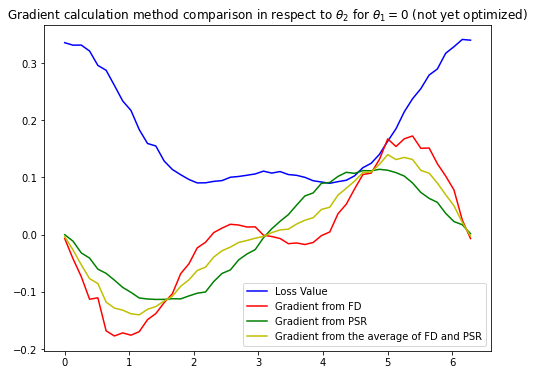

In [706]:
loss = [mse_2([0, i], 1000) for i in angles]
grad_fdm = [fdm(0, i, 1, 1000) for i in angles]
param_shift_vals = [param_shift(0, i, 1, 1000) for i in angles]

plt.plot(angles, loss, 'b', label="Loss Value")
plt.plot(angles, grad_fdm, 'r', label="Gradient from FD")
plt.plot(angles, param_shift_vals, 'g', label="Gradient from PSR")
plt.plot(angles, (np.array(grad_fdm)+np.array(param_shift_vals))/2, 'y', label="Gradient from the average of FD and PSR")
plt.legend()

plt.title("Gradient calculation method comparison in respect to $θ_2$ for $θ_1 = 0$ (not yet optimized)")

plt.show()

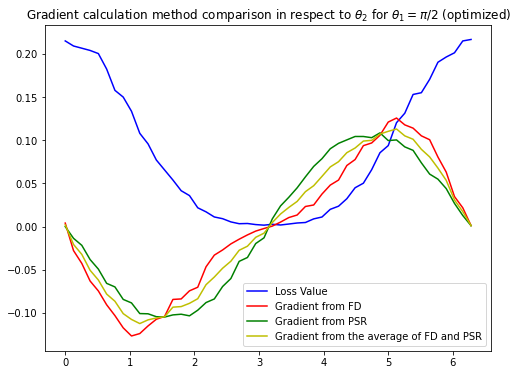

In [707]:
loss = [mse_2([np.pi/2, i], 1000) for i in angles]
grad_fdm = [fdm(np.pi/2, i, 1, 1000) for i in angles]
param_shift_vals = [param_shift(np.pi/2, i, 1, 1000) for i in angles]

plt.plot(angles, loss, 'b', label="Loss Value")
plt.plot(angles, grad_fdm, 'r', label="Gradient from FD")
plt.plot(angles, param_shift_vals, 'g', label="Gradient from PSR")
plt.plot(angles, (np.array(grad_fdm)+np.array(param_shift_vals))/2, 'y', label="Gradient from the average of FD and PSR")
plt.legend()

plt.title("Gradient calculation method comparison in respect to $θ_2$ for $θ_1 = \pi/2$ (optimized)")

plt.show()

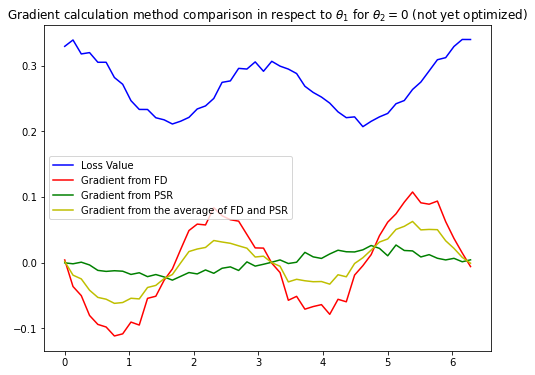

In [708]:
loss = [mse_2([i, 0], 1000) for i in angles]
grad_fdm = [fdm(i, 0, 0, 1000) for i in angles]
param_shift_vals = [param_shift(i, 0, 0, 1000) for i in angles]

plt.plot(angles, loss, 'b', label="Loss Value")
plt.plot(angles, grad_fdm, 'r', label="Gradient from FD")
plt.plot(angles, param_shift_vals, 'g', label="Gradient from PSR")
plt.plot(angles, (np.array(grad_fdm)+np.array(param_shift_vals))/2, 'y', label="Gradient from the average of FD and PSR")
plt.legend()

plt.title("Gradient calculation method comparison in respect to $θ_1$ for $θ_2 = 0$ (not yet optimized)")

plt.show()

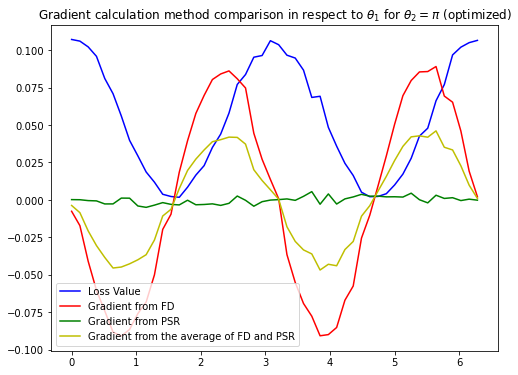

In [710]:
loss = [mse_2([i, np.pi], 1000) for i in angles]
grad_fdm = [fdm(i, np.pi, 0, 1000) for i in angles]
param_shift_vals = [param_shift(i, np.pi, 0, 1000) for i in angles]

plt.plot(angles, loss, 'b', label="Loss Value")
plt.plot(angles, grad_fdm, 'r', label="Gradient from FD")
plt.plot(angles, param_shift_vals, 'g', label="Gradient from PSR")
plt.plot(angles, (np.array(grad_fdm)+np.array(param_shift_vals))/2, 'y', label="Gradient from the average of FD and PSR")
plt.legend()

plt.title("Gradient calculation method comparison in respect to $θ_1$ for $θ_2 = \pi$ (optimized)")

plt.show()

This is a very interesting result. The most noticeable thing is that the gradient values from PSR are very very small (essentially zero) for the case of calculating the gradient with respect to $\theta_{1}$. I did an analytical calculation of PSR to check, it turns out that the probability distributions for $\theta+\frac{\pi}{2}$ and for $\theta+\frac{\pi}{2}$ are very similar, causing $f\left(\theta+\frac{\pi}{2}\right) - f\left(\theta-\frac{\pi}{2}\right) \approx 0$.

PSR thrived when calculating the gradient with respect to $\theta_{2}$. Both graphs for the gradient calculation are relatively very smooth compared to the one from FD. It is also interesting to note that when $\theta_{1} = 0$ (not yet optimized) the FD method's gradient is like the derivative of the loss function when $\theta_{1}$ is not yet optimized (still has 2 minimum points) but the PSR's gradient is like the derivative of the loss function when $\theta_{1} = \frac{\pi}{2}$ (already optimized), as if it already know the shape of the loss function when $\theta_{1}$ is already optimized when $\theta_{1}$ is still zero.

To get the best from both methods, I decided to calculate the gradient by using both methods and averaging the results. We can see the resulting gradients on the plots (the yellow one). This helps PSR in the gradient with respect to $\theta_{1}$, the gradient's value is not always near zero anymore. This also helps FD in the gradient with respect to $\theta_{2}$, it smooth out the plots, and the one with $\theta_{1} = 0$ (not yet optimized) becomes closer to the one with $\theta_{1} = \frac{\pi}{2}$ (already optimized).

In [18]:
# new function to update the parameters
def update_param_2(θ1, θ2, learning_rate, shots):
    θ1_new = θ1 - learning_rate[0]*(fdm(θ1, θ2, 0, shots) + param_shift(θ1, θ2, 0, shots))/2
    θ2_new = θ2 - learning_rate[1]*(fdm(θ1, θ2, 1, shots) + param_shift(θ1, θ2, 1, shots))/2
    
    return θ1_new, θ2_new

Let's test it to see the results. This time I will limit the maximum number of iteration to 1000 and set the initial parameters from random sample with uniform distribution over [0, 0.05).

In [82]:
# INITIALIZATION

# initial constants
max_loss = 0.0001  # maximum loss, the search will be stopped if the loss reachs this number (or lower)
max_iter = 1000  # maximum steps of parameters update

# hyperparameters
shots = [1000, 100, 10, 1]  # number of shots for every measurement
learning_rate = [[0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]
#learning_rate = [[0.1, 0.05], [0.1, 0.05], [0.2, 0.15], [0.6, 0.9]]

# list to save historical data
θ1_history = [np.array([]), np.array([]), np.array([]), np.array([])]
θ2_history = [np.array([]), np.array([]), np.array([]), np.array([])]
error_history = [np.array([]), np.array([]), np.array([]), np.array([])]

In [83]:
# SEARCHING FOR THE PARAMETERS

# loop for every shots
for i in range (len(shots)):

    # initialization
    steps = 0
    θ1 = np.random.rand(1)[0]/20
    θ2 = np.random.rand(1)[0]/20
    error = mse_2([θ1, θ2], shots[i])
    
    # log the historical data
    θ1_history[i] = np.append(θ1_history[i], θ1)
    θ2_history[i] = np.append(θ2_history[i], θ2)
    error_history[i] = np.append(error_history[i], error)

    # searching loop
    while mse_theta(θ1, θ2) > max_loss:
        # target: J(θ1,θ2) <= max_loss

        # update the parameters
        θ1, θ2 = update_param_2(θ1, θ2, learning_rate[i], shots[i])

        # calculate the error
        error = mse_2([θ1, θ2], shots[i])

        # log the historical data
        θ1_history[i] = np.append(θ1_history[i], θ1)
        θ2_history[i] = np.append(θ2_history[i], θ2)
        error_history[i] = np.append(error_history[i], error)

        # increase the step count
        steps += 1

        # if the step count reachs max iter, stop the search
        if steps == max_iter:
            print("Training takes too long. Stopping...")
            break

    # print stuffs
    print("Shots = ", shots[i])
    print("Total Iteration:", steps)
    print("Final angle:" + " θ1 = " + str(θ1) + ", θ2 = " + str(θ2))
    print("Correct/target angle:" + " θ1 = " + str(np.pi/2) + ", θ2 = " + str(np.pi))
    print("Final mean-squared error (as function of θ):", mse_theta(θ1, θ2))
    print("\n")


Shots =  1000
Total Iteration: 165
Final angle: θ1 = 1.5548610133547516, θ2 = 3.106250953976309
Correct/target angle: θ1 = 1.5707963267948966, θ2 = 3.141592653589793
Final mean-squared error (as function of θ): 9.393102848168593e-05


Shots =  100
Total Iteration: 163
Final angle: θ1 = 1.5691004571037022, θ2 = 3.101897773426467
Correct/target angle: θ1 = 1.5707963267948966, θ2 = 3.141592653589793
Final mean-squared error (as function of θ): 9.865669966937943e-05


Shots =  10
Total Iteration: 203
Final angle: θ1 = 1.5423498492301344, θ2 = 3.159699259634775
Correct/target angle: θ1 = 1.5707963267948966, θ2 = 3.141592653589793
Final mean-squared error (as function of θ): 7.106263912861042e-05


Training takes too long. Stopping...
Shots =  1
Total Iteration: 1000
Final angle: θ1 = -0.051393616363782035, θ2 = 3.079899942825358
Correct/target angle: θ1 = 1.5707963267948966, θ2 = 3.141592653589793
Final mean-squared error (as function of θ): 0.15581133934440758




Comparing this results to the results from the first approach, several things can be noted:

1). The searching process using 1 shots did not converge. In the first approach, the gradient is calculated analytically so it is very accurate and performs better, it converged even with only 1 shots. While in the second approach, the average from PSR and FD is used as the gradient, this is an approximation (the FD part) and the uncertainty in the probability distribution is too large for this approximation to be able to converge.

2). But when the second approach converge, the total iteration did not differ too much between different number of shots. For 1000, 100, and 10 shots, the total iteration is about equal.

#### Result Plots

Histogram of the circuit's measurement results using the final angle for 1000 shots


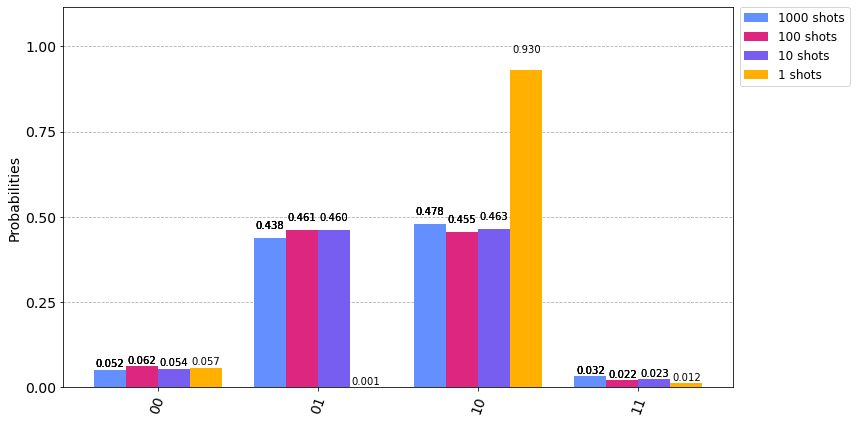

In [95]:
θ1_history = [np.array([1.5548610133547516]), np.array([1.5691004571037022]), np.array([1.5423498492301344]), np.array([-0.051393616363782035])]
θ2_history = [np.array([3.106250953976309]), np.array([3.101897773426467]), np.array([3.159699259634775]), np.array([3.079899942825358])]

print("Histogram of the circuit's measurement results using the final angle for 1000 shots")

# Execute the circuit using the optimized parameters for 1000 shots
counts_1000  = run(circuit(θ1_history[0][-1], θ2_history[0][-1]), 1000)
counts_100  = run(circuit(θ1_history[1][-1], θ2_history[1][-1]), 1000)
counts_10  = run(circuit(θ1_history[2][-1], θ2_history[2][-1]), 1000)
counts_1  = run(circuit(θ1_history[3][-1], θ2_history[3][-1]), 1000)

# Plot results with legend
legend = ['1000 shots', '100 shots', '10 shots', '1 shots']
plot_histogram([counts_1000, counts_100, counts_10, counts_1], legend=legend, figsize=(12,7))


Histogram of the circuit's measurement results using the final angle for 1000 shots (without noise)


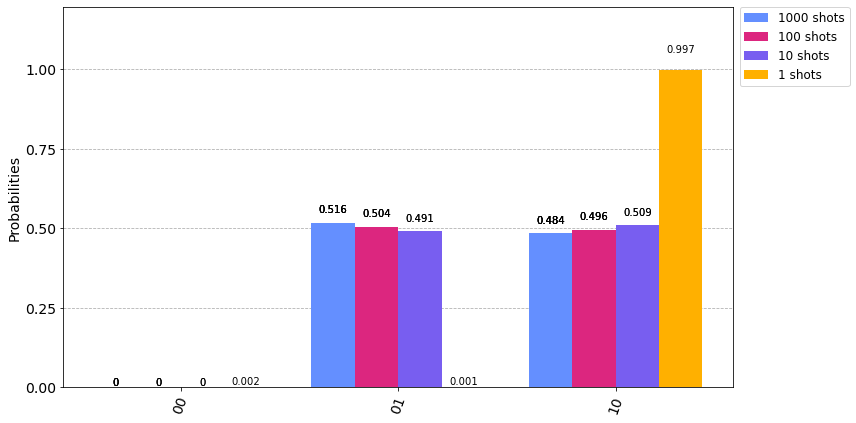

In [96]:
print("Histogram of the circuit's measurement results using the final angle for 1000 shots (without noise)")

# Execute the circuit using the optimized parameters for 1000 shots
counts_1000  = run(circuit(θ1_history[0][-1], θ2_history[0][-1]), 1000, noise_model=0)
counts_100  = run(circuit(θ1_history[1][-1], θ2_history[1][-1]), 1000, noise_model=0)
counts_10  = run(circuit(θ1_history[2][-1], θ2_history[2][-1]), 1000, noise_model=0)
counts_1  = run(circuit(θ1_history[3][-1], θ2_history[3][-1]), 1000, noise_model=0)

# Plot results with legend
legend = ['1000 shots', '100 shots', '10 shots', '1 shots']
plot_histogram([counts_1000, counts_100, counts_10, counts_1], legend=legend, figsize=(12,7))


We get the correct probability distribution that we wanted by using the optimized parameters, except for shots = 1 since it failed to converge.

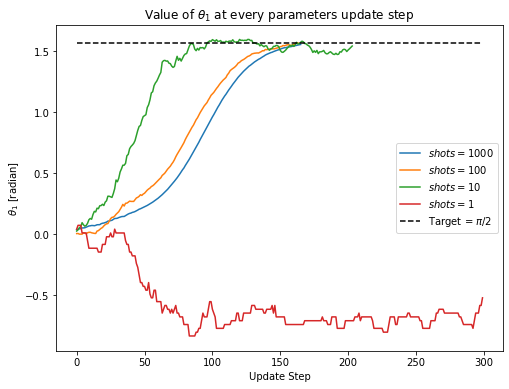

In [84]:
plt.plot(θ1_history[0], label='$shots = 1000$')
plt.plot(θ1_history[1], label='$shots = 100$')
plt.plot(θ1_history[2], label='$shots = 10$')
plt.plot(np.array(θ1_history[3])[:300], label='$shots = 1$')
plt.plot(np.linspace(np.pi/2, np.pi/2, 300), color='black', linestyle='--', label='Target = $\pi/2$')

plt.title('Value of $θ_{1}$ at every parameters update step')
plt.xlabel('Update Step')
plt.ylabel('$θ_{1}$ [radian]')
plt.legend()

plt.show()

For 1 shots, the optimizer failed to converge to the correct value of $\theta_1$. FD method (an approximation) is more dominant in the gradient with respect to $\theta_1$. As expected, an approximation is not good when dealing with system with too much noise. More number of shots is needed to lowered the effect of the noise for this approximation.

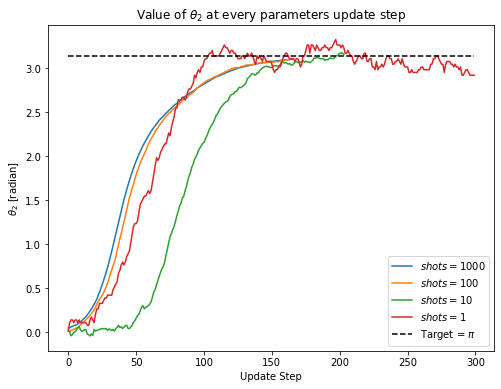

In [85]:
plt.plot(θ2_history[0], label='$shots = 1000$')
plt.plot(θ2_history[1], label='$shots = 100$')
plt.plot(θ2_history[2], label='$shots = 10$')
plt.plot(np.array(θ2_history[3])[:300], label='$shots = 1$')
plt.plot(np.linspace(np.pi, np.pi, 300), color='black', linestyle='--', label='Target = $\pi$')

plt.title('Value of $θ_{2}$ at every parameters update step')
plt.xlabel('Update Step')
plt.ylabel('$θ_{2}$ [radian]')
plt.legend()

plt.show()

Interestingly, for $\theta_2$, all shots were able to converge. PSR is the dominant part in the gradient with respect to $\theta_2$. PSR is theoretically exact (not an approximation), so in theory it should perform better than FD in a noisy condition. This shows that we should use the exact method, e.g. PSR, whenever it can be applied.

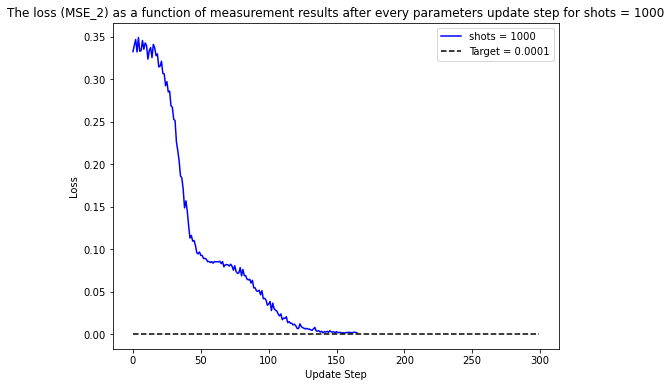

In [86]:
plt.plot(error_history[0], label='shots = 1000', color='blue')
plt.plot(np.linspace(0.0001, 0.0001, 300), color='black', linestyle='--', label='Target = 0.0001')

plt.title('The loss (MSE_2) as a function of measurement results after every parameters update step for shots = 1000')
plt.xlabel('Update Step')
plt.ylabel('Loss')
plt.legend()

plt.show()

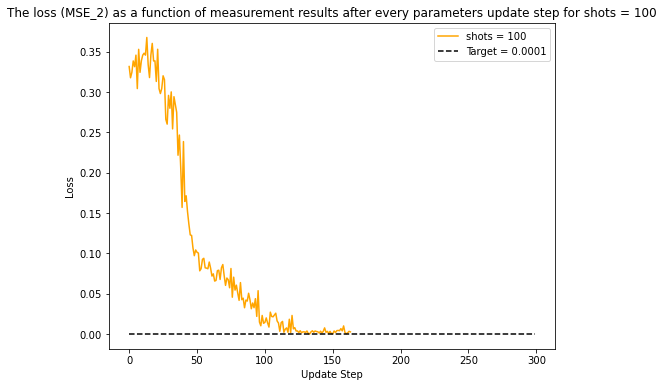

In [87]:
plt.plot(error_history[1], label='shots = 100', color='orange')
plt.plot(np.linspace(0.0001, 0.0001, 300), color='black', linestyle='--', label='Target = 0.0001')

plt.title('The loss (MSE_2) as a function of measurement results after every parameters update step for shots = 100')
plt.xlabel('Update Step')
plt.ylabel('Loss')
plt.legend()

plt.show()

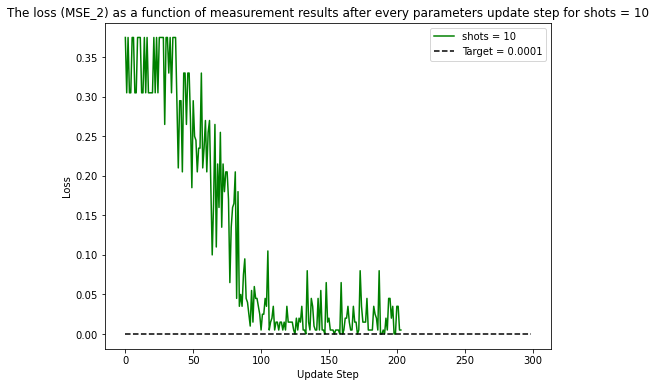

In [88]:
plt.plot(error_history[2], label='shots = 10', color='green')
plt.plot(np.linspace(0.0001, 0.0001, 300), color='black', linestyle='--', label='Target = 0.0001')

plt.title('The loss (MSE_2) as a function of measurement results after every parameters update step for shots = 10')
plt.xlabel('Update Step')
plt.ylabel('Loss')
plt.legend()

plt.show()

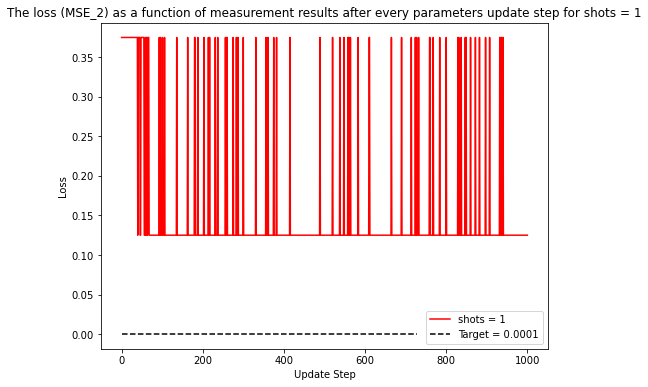

In [89]:
plt.plot(error_history[3], label='shots = 1', color='red')
plt.plot(np.linspace(0.0001, 0.0001, 730), color='black', linestyle='--', label='Target = 0.0001')

plt.title('The loss (MSE_2) as a function of measurement results after every parameters update step for shots = 1')
plt.xlabel('Update Step')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

In agreement with the first approach, MSE that is calculated using the probability distribution from measurement results is inaccurate and unstable. Also, higher number of shots means more stable and accurate MSE. We can see for 1 shots, the MSE is again didn't go down and just went back and forth randomly with about constant average.

### Answer to the bonus question

The answer to the bonus question for the second approach is the same as the first approach since the difference between two approaches is only in the gradient calculation method.

## Conclusions

A program to produce the $\left|\Psi^{+}\right\rangle$ Bell state by using only CNOT and RYs gate optimized by gradient descent has been created with several different approaches to calculate the gradients.

Several main takeaways from this project are:

1). For a very short quantum circuit that we can calculate the equation for the final statevector before hand, it is better to use the exact form of the loss function.

2). This is also true for the gradient calculation, if we can calculate the gradient by hand, then it is better to use it rather than using a more general methods. If we can't calculate it analytically, then using a method that is exact in theory (e.g. Parameter-shift Rule) is better in accuracy than using an approximation (e.g. Finite Difference).

3). Adjust the number of shots wisely. Too many shots will make the searching process slower and redundant. Too few of shots will make the calculation of state's probability inaccurate and the searching process becomes unstable or even impossible.

4). The number of shots, learning rate, and the target loss are related and need to be considered together. High learning rate can compensate with the low shots (unstable probability distribution) to achieve results faster but prone to overshooting and will fail to converge if the target loss is too small.

5). Noise of the simulator or quantum system holds important role in determining the number of shots needed. To get an accurate state's probability distribution, a lot more of shots is needed if the system is noisier.


Thank you so much QOSF for this opportunity, I definitely have learned a lot in these past 2 weeks!

# END